In [1]:
import pandas as pd
import twint
import nest_asyncio
nest_asyncio.apply()
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import sklearn.metrics as metrics
import re
import string
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from datetime import datetime, timedelta
import pandas_datareader.data as pdr
import datetime as dt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\prade\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data Collection with TWINT

In [2]:
# Initialize twint
c = twint.Config()

In [3]:
# Search
# Performed search for both A Pompliano,and Coin bureau for BTC from 2020-10-06 to 2021-10-06

cbbit = 'Bitcoin (from:coinbureau) until:2021-10-06 since:2020-10-06'
c = twint.Config()
c.Search = cbbit
c.Store_csv = True
c.Output = "cbbit.csv"

# Run and save to CSV
twint.run.Search(c)

# Data was collected in CSV file which were concacted with pandas df method, and resaved in csv file

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


### Sentiment anlaysis, and price action for Anthony Pompliano @APompliano

In [4]:
# Re read combined csv
pomp_tweets = pd.read_csv('pompbtc.csv')

In [5]:
pomp_tweets.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1445517131177545738,1445517131177545738,2021-10-05 17:31:55 Central Daylight Time,2021-10-05,17:31:55,-500,339061487,apompliano,Pomp 🌪,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1445486015532072964,1445486015532072964,2021-10-05 15:28:16 Central Daylight Time,2021-10-05,15:28:16,-500,339061487,apompliano,Pomp 🌪,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1445403387680460801,1445403387680460801,2021-10-05 09:59:56 Central Daylight Time,2021-10-05,09:59:56,-500,339061487,apompliano,Pomp 🌪,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1445369324110295043,1445369324110295043,2021-10-05 07:44:35 Central Daylight Time,2021-10-05,07:44:35,-500,339061487,apompliano,Pomp 🌪,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1445362244565487620,1445362244565487620,2021-10-05 07:16:27 Central Daylight Time,2021-10-05,07:16:27,-500,339061487,apompliano,Pomp 🌪,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [6]:
# Dropping unnecessary columns

pomp_tweets = pomp_tweets.drop(['id', 'conversation_id', 'created_at', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'language',
       'urls', 'photos','link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'], axis = 1)



In [7]:
pomp_tweets.head()

,date,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,cashtags
0,2021-10-05,The SEC has just said they will not ban Bitcoi...,[],103,278,2078,[],[]
1,2021-10-05,BREAKING: SEC Chairman Gary Gensler says the S...,[],1002,4483,28691,[],[]
2,2021-10-05,Today's episode of The Best Business Show is ...,"[{'screen_name': 'peterdiamandis', 'name': 'pe...",44,32,190,[],[]
3,2021-10-05,"Bitcoin is closer to $100,000 than it is to $0.",[],496,662,8404,[],[]
4,2021-10-05,New episode with @RaoulGMI is now live! - mac...,"[{'screen_name': 'raoulgmi', 'name': 'raoul pa...",47,50,403,[],[]


In [8]:
# Index changed to date
pomp_tweets.set_index('date',inplace = True)
pomp_tweets.head()

,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,cashtags
date,,,,,,,
2021-10-05,The SEC has just said they will not ban Bitcoi...,[],103,278,2078,[],[]
2021-10-05,BREAKING: SEC Chairman Gary Gensler says the S...,[],1002,4483,28691,[],[]
2021-10-05,Today's episode of The Best Business Show is ...,"[{'screen_name': 'peterdiamandis', 'name': 'pe...",44,32,190,[],[]
2021-10-05,"Bitcoin is closer to $100,000 than it is to $0.",[],496,662,8404,[],[]
2021-10-05,New episode with @RaoulGMI is now live! - mac...,"[{'screen_name': 'raoulgmi', 'name': 'raoul pa...",47,50,403,[],[]


### Obtaining the sentiment score 

In [9]:
# Create single function to build Sentiment Analysis Compound Score column:
def compound_sentiment_columns(text):
    # Function to clean text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    # Function to get compound sentiments
    sentiment = analyzer.polarity_scores(re_clean)
    compound = sentiment["compound"]
    return compound

In [10]:
# Calculating sentiment and adding compound sentiment column
pomp_tweets['compound_sentiment'] = pomp_tweets['tweet'].apply(lambda x:compound_sentiment_columns(x))
pomp_tweets.head()

,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,cashtags,compound_sentiment
date,,,,,,,,
2021-10-05,The SEC has just said they will not ban Bitcoi...,[],103,278,2078,[],[],0.6931
2021-10-05,BREAKING: SEC Chairman Gary Gensler says the S...,[],1002,4483,28691,[],[],-0.7003
2021-10-05,Today's episode of The Best Business Show is ...,"[{'screen_name': 'peterdiamandis', 'name': 'pe...",44,32,190,[],[],0.7783
2021-10-05,"Bitcoin is closer to $100,000 than it is to $0.",[],496,662,8404,[],[],0.0000
2021-10-05,New episode with @RaoulGMI is now live! - mac...,"[{'screen_name': 'raoulgmi', 'name': 'raoul pa...",47,50,403,[],[],0.7579


In [11]:
# Index of DataFrame changed to date
pomp_tweets.index = pd.to_datetime(pomp_tweets.index)
pomp_tweets.head()

,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,cashtags,compound_sentiment
date,,,,,,,,
2021-10-05,The SEC has just said they will not ban Bitcoi...,[],103,278,2078,[],[],0.6931
2021-10-05,BREAKING: SEC Chairman Gary Gensler says the S...,[],1002,4483,28691,[],[],-0.7003
2021-10-05,Today's episode of The Best Business Show is ...,"[{'screen_name': 'peterdiamandis', 'name': 'pe...",44,32,190,[],[],0.7783
2021-10-05,"Bitcoin is closer to $100,000 than it is to $0.",[],496,662,8404,[],[],0.0000
2021-10-05,New episode with @RaoulGMI is now live! - mac...,"[{'screen_name': 'raoulgmi', 'name': 'raoul pa...",47,50,403,[],[],0.7579


## Obtaining BTC price from yahoo

In [12]:
import pandas_datareader.data as pdr
import datetime as dt

In [13]:
start = dt.datetime(2020,10,6)
end = dt.datetime(2021,10,6)
btc_df = pdr.DataReader('BTC-USD','yahoo',start,end)
btc_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-10-05,10803.456055,10565.197266,10799.778320,10621.664062,2.226496e+10,10621.664062
2020-10-06,10687.268555,10591.963867,10619.803711,10679.136719,1.763439e+10,10679.136719
2020-10-07,10939.799805,10569.823242,10677.625000,10923.627930,2.196212e+10,10923.627930
2020-10-09,11442.210938,11056.940430,11059.142578,11296.361328,2.287798e+10,11296.361328
2020-10-10,11428.813477,11288.627930,11296.082031,11384.181641,1.996863e+10,11384.181641


In [14]:
# Dropping all columns except for CLose
btc_df = btc_df.drop(['High','Low','Open','Volume','Adj Close'], axis=1)
btc_df.head()

,Close
Date,
2020-10-05,10621.664062
2020-10-06,10679.136719
2020-10-07,10923.627930
2020-10-09,11296.361328
2020-10-10,11384.181641


In [15]:
# Calculating the daily return
btc_df['returns'] = btc_df['Close'].pct_change()*100
btc_df.head()

,Close,returns
Date,,
2020-10-05,10621.664062,NaN
2020-10-06,10679.136719,0.541089
2020-10-07,10923.627930,2.289429
2020-10-09,11296.361328,3.412176
2020-10-10,11384.181641,0.777421


In [16]:
# Calculating one day lagged return
btc_df['one_day_lagged_return'] = btc_df.returns.shift()
btc_df.head()

,Close,returns,one_day_lagged_return
Date,,,
2020-10-05,10621.664062,NaN,NaN
2020-10-06,10679.136719,0.541089,NaN
2020-10-07,10923.627930,2.289429,0.541089
2020-10-09,11296.361328,3.412176,2.289429
2020-10-10,11384.181641,0.777421,3.412176


In [17]:
# Combining sentiment analysis, and returns in single dataframe
pomp_sentiment_price = pomp_tweets.join(btc_df, how = 'outer')
pomp_sentiment_price.head()

,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,cashtags,compound_sentiment,Close,returns,one_day_lagged_return
2020-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10621.664062,NaN,NaN
2020-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10679.136719,0.541089,NaN
2020-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10923.627930,2.289429,0.541089
2020-10-09,"At this point, you’re violating your fiduciary...",[],89.0,250.0,1398.0,[],[],-0.4416,11296.361328,3.412176,2.289429
2020-10-09,Bitcoin waking up and reminding everyone why i...,[],148.0,254.0,2764.0,[],[],0.0000,11296.361328,3.412176,2.289429


In [18]:
# Dropping null values
pomp_sentiment_price = pomp_sentiment_price.dropna()
pomp_sentiment_price.head()

,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,cashtags,compound_sentiment,Close,returns,one_day_lagged_return
2020-10-09,"At this point, you’re violating your fiduciary...",[],89.0,250.0,1398.0,[],[],-0.4416,11296.361328,3.412176,2.289429
2020-10-09,Bitcoin waking up and reminding everyone why i...,[],148.0,254.0,2764.0,[],[],0.0000,11296.361328,3.412176,2.289429
2020-10-10,63% of bitcoin's circulating supply has not be...,"[{'screen_name': 'yassineark', 'name': 'yassin...",59.0,128.0,1006.0,[],[],0.6731,11384.181641,0.777421,3.412176
2020-10-13,I have no clue why @BlockFi is running a promo...,"[{'screen_name': 'blockfi', 'name': 'blockfi',...",80.0,48.0,300.0,[],[],0.3182,11429.506836,0.398142,0.777421
2020-10-13,@RampCapitalLLC You were asking me how to buy ...,[],2.0,1.0,47.0,[],[],0.0000,11429.506836,0.398142,0.777421


## Assigning X feature, and y target variable

In [59]:
X_pomp = pomp_sentiment_price[['replies_count', 'retweets_count', 'likes_count','compound_sentiment']]
X_pomp

,replies_count,retweets_count,likes_count,compound_sentiment
2020-10-09,89.0,250.0,1398.0,-0.4416
2020-10-09,148.0,254.0,2764.0,0.0000
2020-10-10,59.0,128.0,1006.0,0.6731
2020-10-13,80.0,48.0,300.0,0.3182
2020-10-13,2.0,1.0,47.0,0.0000
...,...,...,...,...
2021-10-05,103.0,278.0,2078.0,0.6931
2021-10-05,1002.0,4483.0,28691.0,-0.7003
2021-10-05,44.0,32.0,190.0,0.7783
2021-10-05,496.0,662.0,8404.0,0.0000


In [60]:
y_pomp = pomp_sentiment_price['one_day_lagged_return']
y_pomp

2020-10-09    2.289429
2020-10-09    2.289429
2020-10-10    3.412176
2020-10-13    0.777421
2020-10-13    0.777421
                ...   
2021-10-05    4.890589
2021-10-05    4.890589
2021-10-05    4.890589
2021-10-05    4.890589
2021-10-05    4.890589
Name: one_day_lagged_return, Length: 1606, dtype: float64

In [61]:
# Splitting the data into training and testing set
X_pomp_train, X_pomp_test, y_pomp_train, y_pomp_test = train_test_split(X_pomp, y_pomp, random_state=10)

In [62]:
#  Define the pipeline for scaling and model fitting
linear_model = Pipeline([
    ("MinMax Scaling", MinMaxScaler()),  
    ("Linear Regression", LinearRegression())
])

sgd_model = Pipeline([
    ("MinMax Scaling", MinMaxScaler()),  
    ("SGD Regression", SGDRegressor())
])


In [63]:
# Using fit function to transform, and fitting the model. 
linear_model.fit(X_pomp_train, y_pomp_train)
sgd_model.fit(X_pomp_train, y_pomp_train)

Pipeline(steps=[('MinMax Scaling', MinMaxScaler()),
                ('SGD Regression', SGDRegressor())])

In [64]:
# Predicting target
y_pomp_pred_linear = linear_model.predict(X_pomp_test)
y_pomp_pred_sgd = sgd_model.predict(X_pomp_test)

In [65]:
# Checking score and absolute error

print('Mean Absolute Error for Linear Regression, A_Pomp: ', mean_absolute_error(y_pomp_pred_linear, y_pomp_test))
print('Score for Linear Regression A_Pomp', linear_model.score(X_pomp_test, y_pomp_test))

print('Mean Absolute Error for SGD Regression, A_Pomp: ', mean_absolute_error(y_pomp_pred_sgd, y_pomp_test))
print('Score for SGD Regression, A_Pomp', sgd_model.score(X_pomp_test, y_pomp_test))

Mean Absolute Error for Linear Regression, A_Pomp:  3.427330562261766
Score for Linear Regression A_Pomp 0.0020121314709111715
Mean Absolute Error for SGD Regression, A_Pomp:  3.4305422082489554
Score for SGD Regression, A_Pomp -3.168757747662454e-05


## Data Visualization

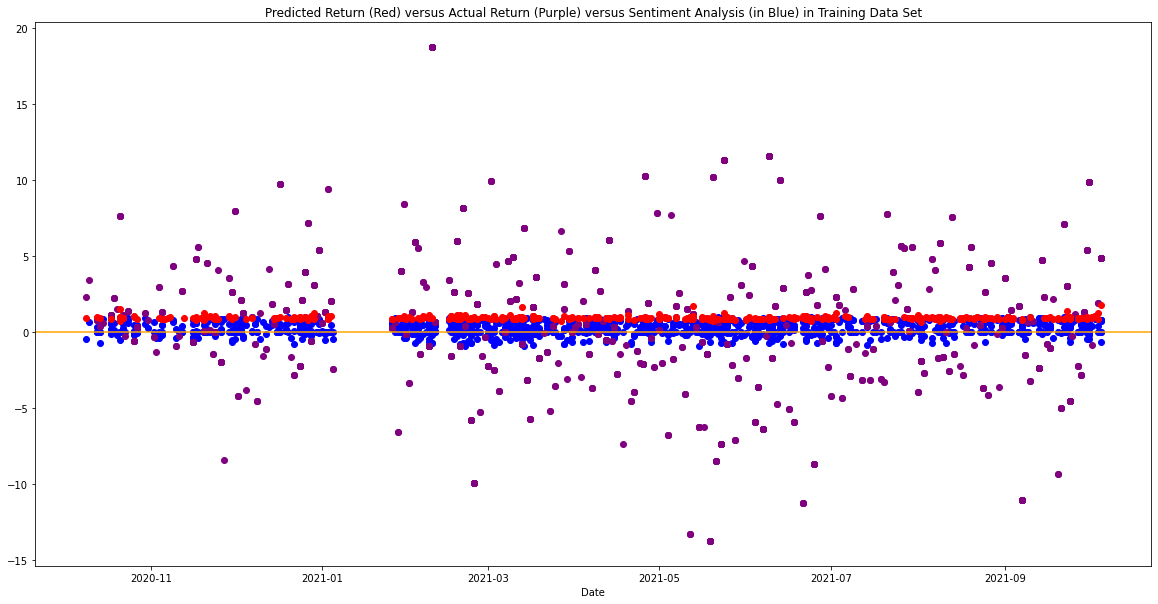

In [66]:
plt.figure(figsize=(20,10))
plt.scatter(X_pomp_train.index, X_pomp_train['compound_sentiment'], color = 'blue')
plt.scatter(X_pomp_train.index, y_pomp_train, color = 'purple')
plt.scatter(X_pomp_test.index, y_pomp_pred_linear, color='red')
plt.axhline(0, color='orange')
plt.xlabel('Date')
plt.title('Predicted Return (Red) versus Actual Return (Purple) versus Sentiment Analysis (in Blue) in Training Data Set')
plt.show()

In [67]:
plt.savefig('pomp_tweet_BTC_returns.png')

<Figure size 432x288 with 0 Axes>

### Sentiment anlaysis, and price action for twitter handle @CoinBureau

In [26]:
# Re read combined csv
coinbureau_tweets = pd.read_csv('coinbureaubtc.csv')

In [27]:
coinbureau_tweets.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1394684985357991937,1394684985357991937,2021-05-18 11:03:07 Central Daylight Time,2021-05-18,11:03:07,-500,906230721513181184,coinbureau,Coin Bureau (guy.eth),NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1394324644887400455,1394324644887400455,2021-05-17 11:11:15 Central Daylight Time,2021-05-17,11:11:15,-500,906230721513181184,coinbureau,Coin Bureau (guy.eth),NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1394239635749015554,1394239635749015554,2021-05-17 05:33:27 Central Daylight Time,2021-05-17,05:33:27,-500,906230721513181184,coinbureau,Coin Bureau (guy.eth),NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1393958983958814726,1393958983958814726,2021-05-16 10:58:14 Central Daylight Time,2021-05-16,10:58:14,-500,906230721513181184,coinbureau,Coin Bureau (guy.eth),NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1393853568797577216,1393853568797577216,2021-05-16 03:59:22 Central Daylight Time,2021-05-16,03:59:22,-500,906230721513181184,coinbureau,Coin Bureau (guy.eth),NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [28]:
# Dropping unnecessary columns

coinbureau_tweets = coinbureau_tweets.drop(['id', 'conversation_id', 'created_at', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'language',
       'urls', 'photos','link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'], axis = 1)


In [29]:
coinbureau_tweets.head()

,date,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,cashtags
0,2021-05-18,"#Litecoin is the OG altcoin. The ""silver"" to B...",[],72,93,885,['litecoin'],['ltc']
1,2021-05-17,Coin Bureau Weekly News is live! We have a lot...,[],22,47,468,['bitcoin'],[]
2,2021-05-17,Looking forward to the Coin Bureau Weekly news...,[],173,75,2461,['bitcoin'],['ada']
3,2021-05-16,#Bitcoin has become a global asset that is dri...,[],28,50,554,['bitcoin'],[]
4,2021-05-16,Most people overestimate their #crypto gains i...,[],51,77,808,"['crypto', 'bitcoin']",[]


In [30]:
# Index changed to date
coinbureau_tweets.set_index('date',inplace = True)
coinbureau_tweets.head()

,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,cashtags
date,,,,,,,
2021-05-18,"#Litecoin is the OG altcoin. The ""silver"" to B...",[],72,93,885,['litecoin'],['ltc']
2021-05-17,Coin Bureau Weekly News is live! We have a lot...,[],22,47,468,['bitcoin'],[]
2021-05-17,Looking forward to the Coin Bureau Weekly news...,[],173,75,2461,['bitcoin'],['ada']
2021-05-16,#Bitcoin has become a global asset that is dri...,[],28,50,554,['bitcoin'],[]
2021-05-16,Most people overestimate their #crypto gains i...,[],51,77,808,"['crypto', 'bitcoin']",[]


## Obtaining the sentiment score

In [31]:
# Create single function to build Sentiment Analysis Compound Score column:
def compound_sentiment_columns(text):
    # Function to clean text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    # Function to get compound sentiments
    sentiment = analyzer.polarity_scores(re_clean)
    compound = sentiment["compound"]
    return compound

In [32]:
# Calculating sentiment and adding compound sentiment column
coinbureau_tweets['compound_sentiment'] = coinbureau_tweets['tweet'].apply(lambda x:compound_sentiment_columns(x))
coinbureau_tweets.head()

,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,cashtags,compound_sentiment
date,,,,,,,,
2021-05-18,"#Litecoin is the OG altcoin. The ""silver"" to B...",[],72,93,885,['litecoin'],['ltc'],-0.3612
2021-05-17,Coin Bureau Weekly News is live! We have a lot...,[],22,47,468,['bitcoin'],[],0.5052
2021-05-17,Looking forward to the Coin Bureau Weekly news...,[],173,75,2461,['bitcoin'],['ada'],0.0000
2021-05-16,#Bitcoin has become a global asset that is dri...,[],28,50,554,['bitcoin'],[],0.6124
2021-05-16,Most people overestimate their #crypto gains i...,[],51,77,808,"['crypto', 'bitcoin']",[],-0.7391


In [33]:
# Index of DataFrame changed to date
coinbureau_tweets.index = pd.to_datetime(coinbureau_tweets.index)
coinbureau_tweets.head()

,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,cashtags,compound_sentiment
date,,,,,,,,
2021-05-18,"#Litecoin is the OG altcoin. The ""silver"" to B...",[],72,93,885,['litecoin'],['ltc'],-0.3612
2021-05-17,Coin Bureau Weekly News is live! We have a lot...,[],22,47,468,['bitcoin'],[],0.5052
2021-05-17,Looking forward to the Coin Bureau Weekly news...,[],173,75,2461,['bitcoin'],['ada'],0.0000
2021-05-16,#Bitcoin has become a global asset that is dri...,[],28,50,554,['bitcoin'],[],0.6124
2021-05-16,Most people overestimate their #crypto gains i...,[],51,77,808,"['crypto', 'bitcoin']",[],-0.7391


In [34]:
# Combining sentiment analysis, and returns in single dataframe
coinbureau_sentiment_price = coinbureau_tweets.join(btc_df, how = 'outer')
coinbureau_sentiment_price.head()

,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,cashtags,compound_sentiment,Close,returns,one_day_lagged_return
2020-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10621.664062,NaN,NaN
2020-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10679.136719,0.541089,NaN
2020-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10923.627930,2.289429,0.541089
2020-10-09,This is some pretty exciting research for #Mon...,[],1.0,7.0,22.0,"['monero', 'bitcoin']","['xmr', 'btc']",0.7506,11296.361328,3.412176,2.289429
2020-10-09,Only $50m into #Bitcoin Square? You can do bet...,[],3.0,1.0,29.0,['bitcoin'],[],0.4404,11296.361328,3.412176,2.289429


In [35]:
# Dropping null values
coinbureau_sentiment_price = coinbureau_sentiment_price.dropna()
coinbureau_sentiment_price.head()

,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,cashtags,compound_sentiment,Close,returns,one_day_lagged_return
2020-10-09,This is some pretty exciting research for #Mon...,[],1.0,7.0,22.0,"['monero', 'bitcoin']","['xmr', 'btc']",0.7506,11296.361328,3.412176,2.289429
2020-10-09,Only $50m into #Bitcoin Square? You can do bet...,[],3.0,1.0,29.0,['bitcoin'],[],0.4404,11296.361328,3.412176,2.289429
2020-10-10,Another tired cliche being propagated by the D...,[],4.0,4.0,34.0,"['crypto', 'bitcoin']",[],-0.1280,11384.181641,0.777421,3.412176
2020-10-10,Stimulus cheques could be around the corner. H...,[],2.0,4.0,38.0,"['stimulus', 'bitcoin']",[],0.6249,11384.181641,0.777421,3.412176
2020-10-13,"Damn, another one. They just had to find a #bi...",[],1.0,1.0,6.0,['bitcoin'],[],-0.4019,11429.506836,0.398142,0.777421


In [36]:
coinbureau_sentiment_price.shape

(542, 11)

## Assigning X feature, and y target variable

In [46]:
X_bureau = coinbureau_sentiment_price[['replies_count', 'retweets_count', 'likes_count','compound_sentiment']]
X_bureau.shape

(542, 4)

In [47]:
y_bureau = coinbureau_sentiment_price['one_day_lagged_return']
y_bureau.shape

(542,)

In [48]:
# Splitting the data into training and testing set
X_bureau_train, X_bureau_test, y_bureau_train, y_bureau_test = train_test_split(X_bureau, y_bureau, random_state=10)

In [49]:
#  Define the pipeline for scaling and model fitting
linear_model = Pipeline([
    ("MinMax Scaling", MinMaxScaler()),  
    ("Linear Regression", LinearRegression())
])

sgd_model = Pipeline([
    ("MinMax Scaling", MinMaxScaler()),  
    ("SGD Regression", SGDRegressor())
])

In [54]:
# Using fit function to transform, and fitting the model. 
linear_model.fit(X_bureau_train, y_bureau_train)
sgd_model.fit(X_bureau_train, y_bureau_train)

Pipeline(steps=[('MinMax Scaling', MinMaxScaler()),
                ('SGD Regression', SGDRegressor())])

In [55]:
# Predicting target
y_bureau_pred_linear = linear_model.predict(X_bureau_test)
y_bureau_pred_sgd = sgd_model.predict(X_bureau_test)

In [56]:
# Checking score and absolute error

print('Mean Absolute Error for Linear Regression, coin_bureau: ', mean_absolute_error(y_bureau_pred_linear, y_bureau_test))
print('Score for Linear Regression, coin_bureau', linear_model.score(X_bureau_test, y_bureau_test))

print('Mean Absolute Error for SGD Regression, coin_bureau: ', mean_absolute_error(y_bureau_pred_sgd, y_bureau_test))
print('Score for SGD Regression, coin_bureau', sgd_model.score(X_bureau_test, y_bureau_test))

Mean Absolute Error for Linear Regression, coin_bureau:  3.3380611018284925
Score for Linear Regression, coin_bureau 0.043975937202313076
Mean Absolute Error for SGD Regression, coin_bureau:  3.3682481579053043
Score for SGD Regression, coin_bureau 0.011145334056612777


## Data Visualization

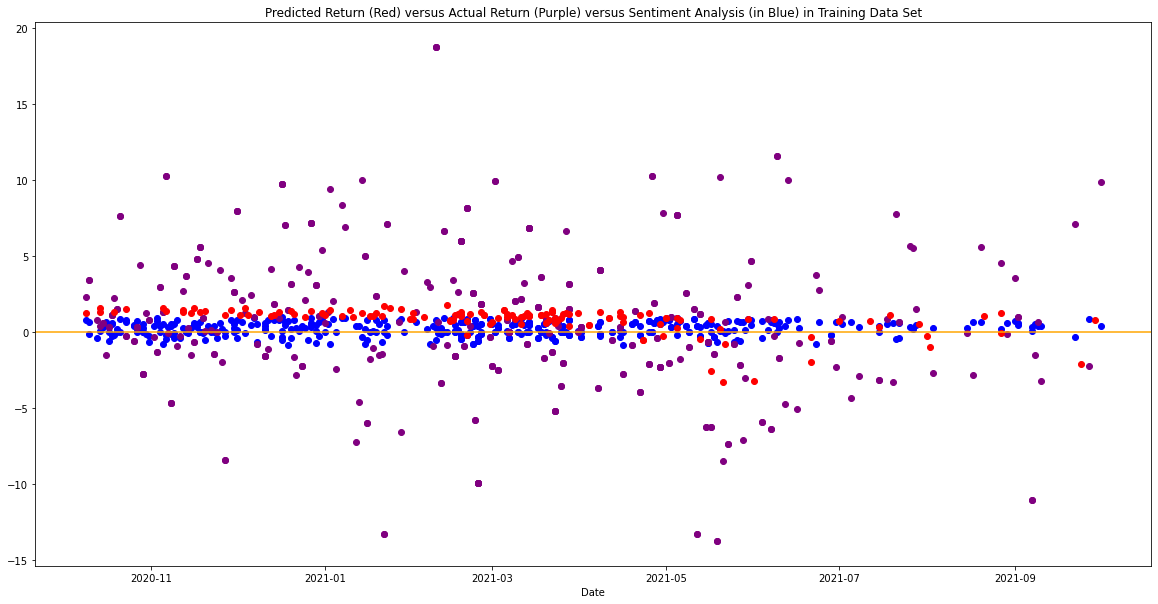

In [58]:
plt.figure(figsize=(20,10))
plt.scatter(X_bureau_train.index, X_bureau_train['compound_sentiment'], color = 'blue')
plt.scatter(X_bureau_train.index, y_bureau_train, color = 'purple')
plt.scatter(X_bureau_test.index, y_bureau_pred_linear, color='red')
plt.axhline(0, color='orange')
plt.xlabel('Date')
plt.title('Predicted Return (Red) versus Actual Return (Purple) versus Sentiment Analysis (in Blue) in Training Data Set')
plt.show()

In [68]:
plt.savefig('bureau_tweet_BTC_returns.png')

<Figure size 432x288 with 0 Axes>

## Thank you